In [1]:
import os
import sys
import yaml
import torch
import logging
import argparse
import numpy as np
#import seaborn as sn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
from torchmetrics.functional import mean_squared_error as mse
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
sys.path.append('../')
from utils import parameter_manager, model_loader
from core import datamodule, lrn, modulator, propagator, classifiers, cooperative

#plt.style.use('seaborn-v0_8')

/cgi/data/jupyterhub/lindsaymb00/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load parameters
params = yaml.load(open('../config.yaml'), Loader = yaml.FullLoader)
params['batch_size'] = 1
params['distance'] = torch.tensor(0.01)
params['path_root'] = '/cgi/data/erdc_xai/resolution_constrained_deep_optics/'
os.environ['TORCH_HOME'] = '/cgi/data/erdc_xai/resolution_constrained_deep_optics/pretrained_models/'
pm = parameter_manager.Parameter_Manager(params = params)
# Load in the test dataset
pm.data_split = "mnist_1000perClass"
datamod = datamodule.select_data(pm.params_datamodule)
datamod.setup()
dataloader_train_1000perClass = datamod.train_dataloader()
dataloader_test = datamod.test_dataloader()

In [3]:
number = 500
for i,(image,target) in enumerate(dataloader_test):
    if i == number:
        break
batch = (image,target)

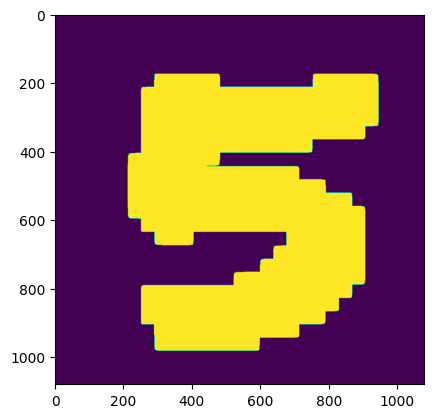

In [4]:
plt.imshow(image.squeeze().abs().detach())

In [5]:
path_cooperative = '/cgi/data/erdc_xai/resolution_constrained_deep_optics/my_models/cooperative/'
path_lrn = '/cgi/data/erdc_xai/resolution_constrained_deep_optics/my_models/lrn/'

lrn_lensInit_folders = os.listdir(os.path.join(path_lrn, "lensInit"))
lrn_lensInit_folders.sort()

lrn_randomInit_folders = os.listdir(os.path.join(path_lrn, "randomInit"))
lrn_randomInit_folders.sort()

cooperative_analyticalLrn_folders = os.listdir(os.path.join(path_cooperative, "analyticalLensInit"))
cooperative_analyticalLrn_folders.sort()

cooperative_analyticalLrnOptim_folders = os.listdir(os.path.join(path_cooperative, "analyticalLensInit_optimizable"))
cooperative_analyticalLrnOptim_folders.sort()

cooperative_randomLrnOptim_folders = os.listdir(os.path.join(path_cooperative, "randomLensInit_optimizable"))
cooperative_randomLrnOptim_folders.sort()

cooperative_trainedLrnLens_folders = os.listdir(os.path.join(path_cooperative, "trainedLrn_lensInit"))
cooperative_trainedLrnLens_folders.sort()

cooperative_trainedLrnRandom_folders = os.listdir(os.path.join(path_cooperative, "trainedLrn_randomInit"))
cooperative_trainedLrnRandom_folders.sort()

print(len(lrn_lensInit_folders))
print(len(lrn_randomInit_folders))
print(len(cooperative_analyticalLrn_folders))
print(len(cooperative_analyticalLrnOptim_folders))
print(len(cooperative_randomLrnOptim_folders))
print(len(cooperative_trainedLrnLens_folders))
print(len(cooperative_trainedLrnRandom_folders))

101
101
101
101
101
101
101


In [6]:
distances = []
for f in lrn_lensInit_folders:
    distances.append(torch.tensor(float(f.split('_')[-1])))   
distances = torch.stack(distances)
print(distances)
integer = 20
distances = [torch.round(distances[i*integer],decimals=3) for i in range(0,len(distances)//integer)]
distances.append(torch.tensor(float(0.1)))
print(distances)

tensor([0.0100, 0.0109, 0.0118, 0.0127, 0.0136, 0.0145, 0.0154, 0.0163, 0.0172,
        0.0181, 0.0190, 0.0199, 0.0208, 0.0217, 0.0226, 0.0235, 0.0244, 0.0253,
        0.0262, 0.0271, 0.0280, 0.0289, 0.0298, 0.0307, 0.0316, 0.0325, 0.0334,
        0.0343, 0.0352, 0.0361, 0.0370, 0.0379, 0.0388, 0.0397, 0.0406, 0.0415,
        0.0424, 0.0433, 0.0442, 0.0451, 0.0460, 0.0469, 0.0478, 0.0487, 0.0496,
        0.0505, 0.0514, 0.0523, 0.0532, 0.0541, 0.0550, 0.0559, 0.0568, 0.0577,
        0.0586, 0.0595, 0.0604, 0.0613, 0.0622, 0.0631, 0.0640, 0.0649, 0.0658,
        0.0667, 0.0676, 0.0685, 0.0694, 0.0703, 0.0712, 0.0721, 0.0730, 0.0739,
        0.0748, 0.0757, 0.0766, 0.0775, 0.0784, 0.0793, 0.0802, 0.0811, 0.0820,
        0.0829, 0.0838, 0.0847, 0.0856, 0.0865, 0.0874, 0.0883, 0.0892, 0.0901,
        0.0910, 0.0919, 0.0928, 0.0937, 0.0946, 0.0955, 0.0964, 0.0973, 0.0982,
        0.0991, 0.1000])
[tensor(0.0100), tensor(0.0280), tensor(0.0460), tensor(0.0640), tensor(0.0820), tensor(0.1000)

In [7]:
bad_distances = np.array([0.0199, 0.0352, 0.0361, 0.0406, 0.0433, 0.0442, 0.046 , 0.0505,
       0.0514, 0.0532, 0.055 , 0.0559, 0.0577, 0.0586, 0.0595, 0.0613,
       0.0649, 0.0658, 0.0676, 0.0685, 0.0694, 0.0712, 0.073 , 0.0739,
       0.0757, 0.0766, 0.082 , 0.0829, 0.0847, 0.0865, 0.0901, 0.0937,
       0.0946, 0.0955, 0.0991, 0.1   ])

good_distances = np.array([0.01  , 0.0109, 0.0118, 0.0127, 0.0136, 0.0145, 0.0154, 0.0163,
       0.0172, 0.0181, 0.019 , 0.0208, 0.0217, 0.0226, 0.0235, 0.0244,
       0.0253, 0.0262, 0.0271, 0.028 , 0.0289, 0.0298, 0.0307, 0.0316,
       0.0325, 0.0334, 0.0343, 0.037 , 0.0379, 0.0388, 0.0397, 0.0415,
       0.0424, 0.0451, 0.0469, 0.0478, 0.0487, 0.0496, 0.0523, 0.0541,
       0.0568, 0.0604, 0.0622, 0.0631, 0.064 , 0.0667, 0.0703, 0.0721,
       0.0748, 0.0775, 0.0784, 0.0793, 0.0802, 0.0811, 0.0838, 0.0856,
       0.0874, 0.0883, 0.0892, 0.091 , 0.0919, 0.0928, 0.0964, 0.0973,
       0.0982])

---
---
---

In [8]:
image_distances = np.asarray([
'0.0199',
'0.0316',
'0.0433',
'0.0550',
'0.0667',
'0.0784',
'0.0901',
'0.1000'], dtype='U6')

float_distances  = np.asarray([
0.0199,
0.0316,
0.0433,
0.0550,
0.0667,
0.0784,
0.0901,
0.1000])


print((float_distances) * 50)
#output_wavefronts, amplitudes, normalized_amplitudes, images, normalized_images, target

[0.995 1.58  2.165 2.75  3.335 3.92  4.505 5.   ]


In [9]:
outputs = {}

for f in tqdm(cooperative_analyticalLrn_folders):
    #print(f)
    if (np.repeat(f.split('_')[-1],len(image_distances)) == image_distances).any():
        checkpoint = os.path.join(path_cooperative,"analyticalLensInit",f,'epoch=4-step=6250.ckpt')
        
        model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint)        
                
        outputs['{}'.format(f)] = model.shared_step(batch, 0), model.lrn.layers[1].phase

  0%|          | 0/101 [00:00<?, ?it/s]/cgi/home/lindsaymb/workspace/documents/code/rcdo/evaluations/../core/lrn.py:165: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:250.)
  target = sample.double()
100%|██████████| 101/101 [00:10<00:00,  9.34it/s]


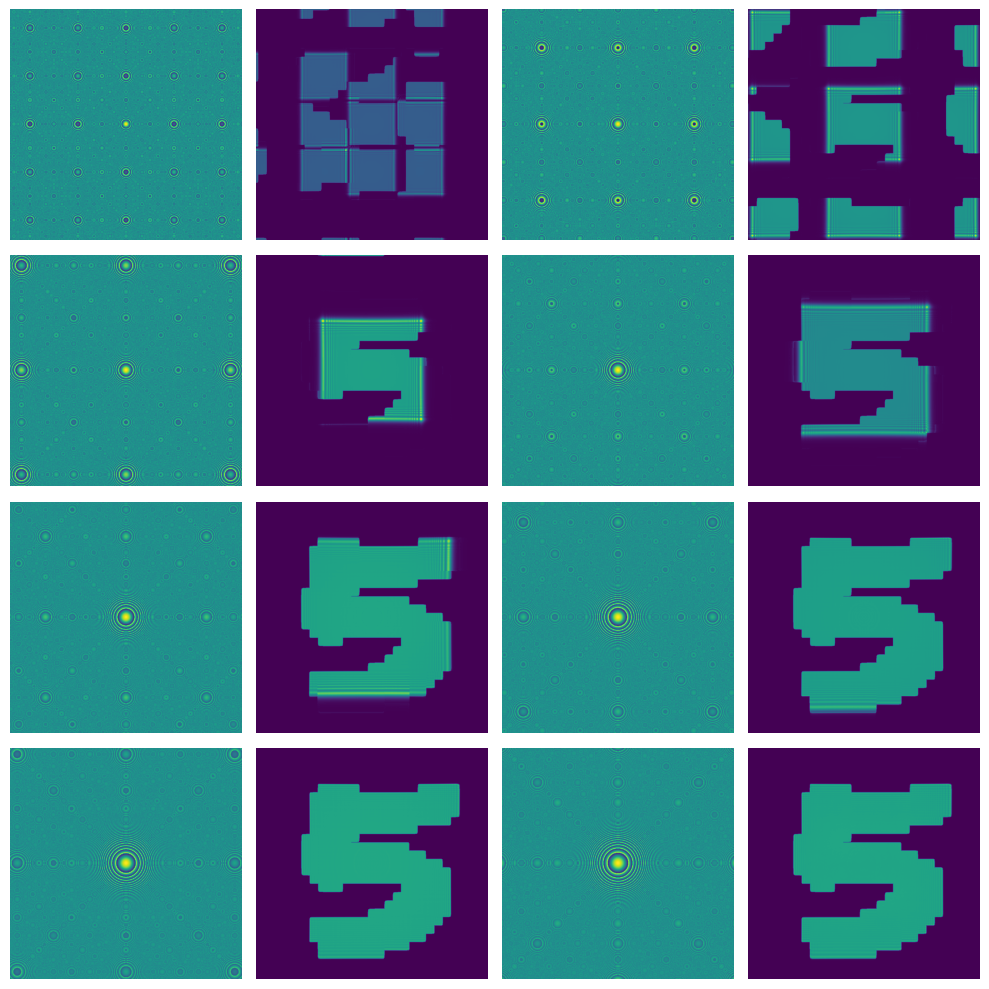

In [10]:
fig,ax = plt.subplots(4,4, figsize=(10,10))

images = []
lenses = []

for i,k in enumerate(outputs):
    col = i%2
    row = i//2
    
    #print(row,col)
    
    image = outputs[k][0][0][4].squeeze()
    lens = outputs[k][-1].detach().squeeze() % (np.pi *2)
    
    images.append(image)
    lenses.append(lens)

    
ax[0][0].imshow(lenses[0])
ax[0][1].imshow(images[0])

ax[0][2].imshow(lenses[1])
ax[0][3].imshow(images[1])

ax[1][0].imshow(lenses[2])
ax[1][1].imshow(images[2])

ax[1][2].imshow(lenses[3])
ax[1][3].imshow(images[3])

ax[2][0].imshow(lenses[4])
ax[2][1].imshow(images[4])

ax[2][2].imshow(lenses[5])
ax[2][3].imshow(images[5])

ax[3][0].imshow(lenses[6])
ax[3][1].imshow(images[6])

ax[3][2].imshow(lenses[7])
ax[3][3].imshow(images[7])
    
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i,j].axis('off')
        
plt.tight_layout()
fig.savefig("baseline_images_lenses.pdf")

In [20]:
outputs = {}

for f in tqdm(cooperative_analyticalLrnOptim_folders):
    #print(f)
    if (np.repeat(f.split('_')[-1],len(image_distances)) == image_distances).any():
        f = f.split('_')[-1]
        
        checkpoint = os.path.join(path_cooperative,"analyticalLensInit_optimizable",'coop_optim_{}'.format(f),'epoch=4-step=6250.ckpt')
        
        model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint)
        
        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)
        #checkpoint = torch.load(checkpoint)
        #checkpoint = torch.load(checkpoint)
        #state_dict = checkpoint['state_dict']

        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)        
        
        #model.load_state_dict(state_dict)
        
        # model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint, 
        #                                      params_model_cooperative = pm.params_model_cooperative,
        #                                      params_model_lrn = pm.params_model_lrn, 
        #                                      params_propagator = pm.params_propagator, 
        #                                      params_modulator = pm.params_modulator, 
        #                                      params_model_classifier = pm.params_model_classifier, 
        #                                      all_paths = pm.all_paths)

        outputs['{}'.format(f)] = model.shared_step(batch, 0), model.lrn.layers[1].phase

100%|██████████| 101/101 [00:12<00:00,  7.78it/s]


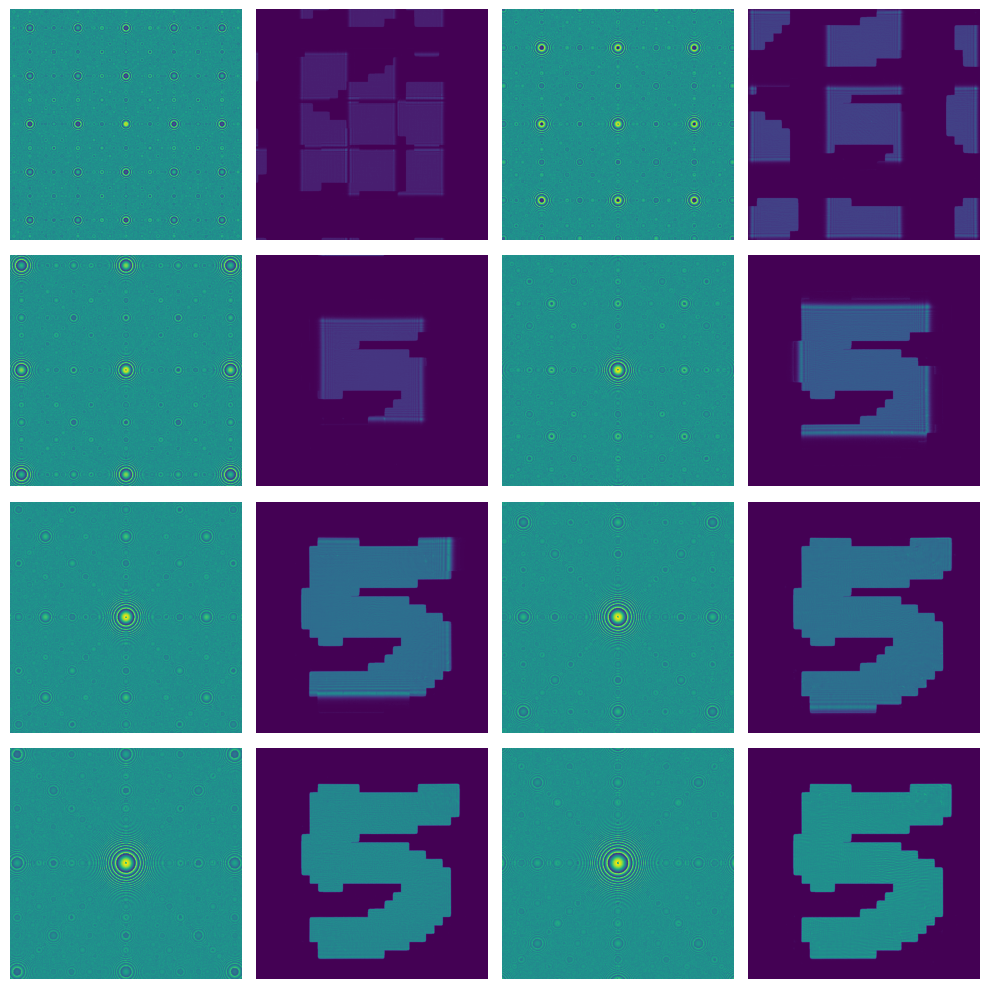

In [23]:
fig,ax = plt.subplots(4,4, figsize=(10,10))

images = []
lenses = []

for i,k in enumerate(outputs):
    col = i%2
    row = i//2
    
    #print(row,col)
    
    image = outputs[k][0][0][3].squeeze().detach()
    lens = outputs[k][-1].detach().squeeze() % (np.pi *2)
    
    images.append(image)
    lenses.append(lens)

    
ax[0][0].imshow(lenses[0])
ax[0][1].imshow(images[0])

ax[0][2].imshow(lenses[1])
ax[0][3].imshow(images[1])

ax[1][0].imshow(lenses[2])
ax[1][1].imshow(images[2])

ax[1][2].imshow(lenses[3])
ax[1][3].imshow(images[3])

ax[2][0].imshow(lenses[4])
ax[2][1].imshow(images[4])

ax[2][2].imshow(lenses[5])
ax[2][3].imshow(images[5])

ax[3][0].imshow(lenses[6])
ax[3][1].imshow(images[6])

ax[3][2].imshow(lenses[7])
ax[3][3].imshow(images[7])
    
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i,j].axis('off')
        
plt.tight_layout()
fig.savefig("analyticalInit_classifierOptimized.pdf")

In [24]:
outputs = {}

for f in tqdm(cooperative_randomLrnOptim_folders):
    #print(f)
    if (np.repeat(f.split('_')[-1],len(image_distances)) == image_distances).any():
        f = f.split('_')[-1]
        
        checkpoint = os.path.join(path_cooperative,"randomLensInit_optimizable",'coop_optim_{}'.format(f),'epoch=4-step=6250.ckpt')
        
        model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint)
        
        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)
        #checkpoint = torch.load(checkpoint)
        #checkpoint = torch.load(checkpoint)
        #state_dict = checkpoint['state_dict']

        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)        
        
        #model.load_state_dict(state_dict)
        
        # model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint, 
        #                                      params_model_cooperative = pm.params_model_cooperative,
        #                                      params_model_lrn = pm.params_model_lrn, 
        #                                      params_propagator = pm.params_propagator, 
        #                                      params_modulator = pm.params_modulator, 
        #                                      params_model_classifier = pm.params_model_classifier, 
        #                                      all_paths = pm.all_paths)

        outputs['{}'.format(f)] = model.shared_step(batch, 0), model.lrn.layers[1].phase

100%|██████████| 101/101 [00:14<00:00,  6.83it/s]


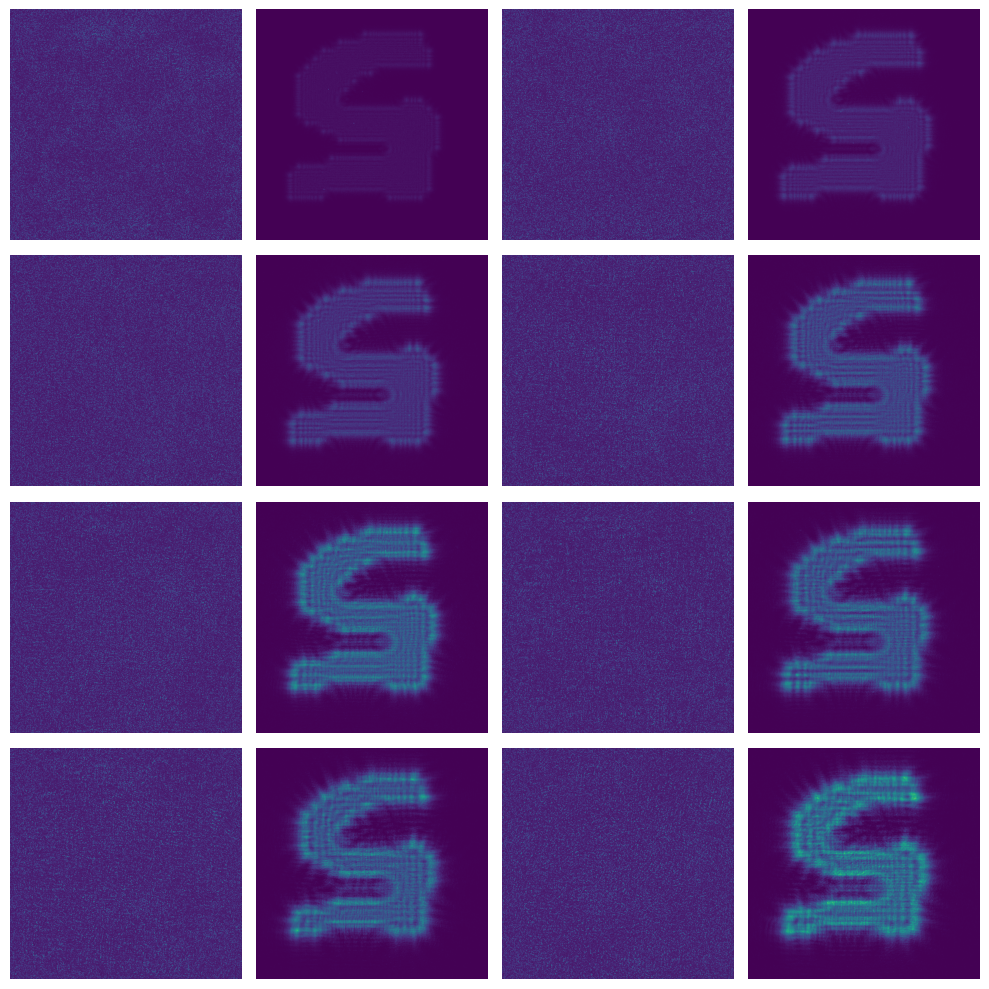

In [25]:
fig,ax = plt.subplots(4,4, figsize=(10,10))

images = []
lenses = []

for i,k in enumerate(outputs):
    col = i%2
    row = i//2
    
    #print(row,col)
    
    image = outputs[k][0][0][3].squeeze().detach()
    lens = outputs[k][-1].detach().squeeze() % (np.pi *2)
    
    images.append(image)
    lenses.append(lens)

    
ax[0][0].imshow(lenses[0])
ax[0][1].imshow(images[0])

ax[0][2].imshow(lenses[1])
ax[0][3].imshow(images[1])

ax[1][0].imshow(lenses[2])
ax[1][1].imshow(images[2])

ax[1][2].imshow(lenses[3])
ax[1][3].imshow(images[3])

ax[2][0].imshow(lenses[4])
ax[2][1].imshow(images[4])

ax[2][2].imshow(lenses[5])
ax[2][3].imshow(images[5])

ax[3][0].imshow(lenses[6])
ax[3][1].imshow(images[6])

ax[3][2].imshow(lenses[7])
ax[3][3].imshow(images[7])
    
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i,j].axis('off')
        
plt.tight_layout()
fig.savefig("randomInit_classifierOptimized.pdf")

In [28]:
outputs = {}

for f in tqdm(lrn_lensInit_folders):
    #print(f)
    if (np.repeat(f.split('_')[-1],len(image_distances)) == image_distances).any():
        f = f.split('_')[-1]
        
        checkpoint = os.path.join(path_lrn,"lensInit",'lrn_{}'.format(f),'epoch=4-step=6250.ckpt')
        
        model = lrn.LRN.load_from_checkpoint(checkpoint)
        
        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)
        #checkpoint = torch.load(checkpoint)
        #checkpoint = torch.load(checkpoint)
        #state_dict = checkpoint['state_dict']

        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)        
        
        #model.load_state_dict(state_dict)
        
        # model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint, 
        #                                      params_model_cooperative = pm.params_model_cooperative,
        #                                      params_model_lrn = pm.params_model_lrn, 
        #                                      params_propagator = pm.params_propagator, 
        #                                      params_modulator = pm.params_modulator, 
        #                                      params_model_classifier = pm.params_model_classifier, 
        #                                      all_paths = pm.all_paths)

        outputs['{}'.format(f)] = model.shared_step(batch, 0), model.layers[1].phase

100%|██████████| 101/101 [00:06<00:00, 16.80it/s]


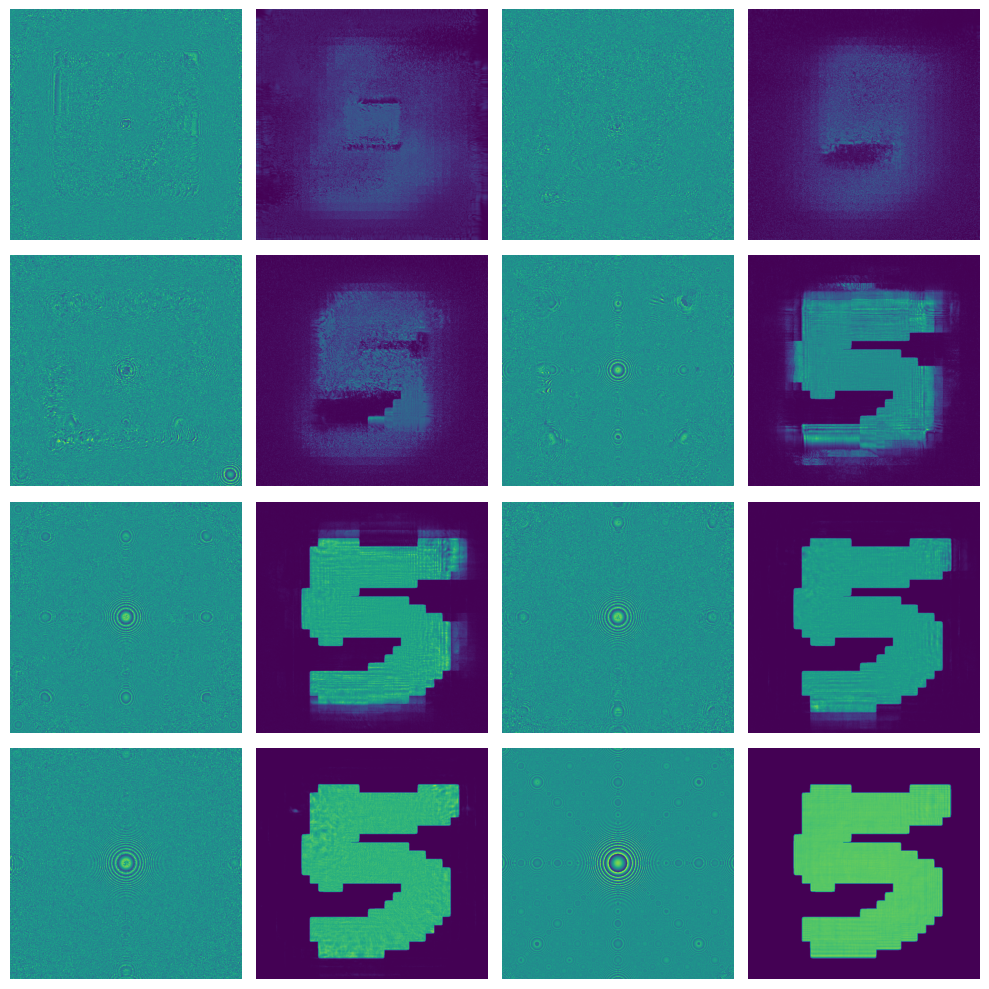

In [30]:
fig,ax = plt.subplots(4,4, figsize=(10,10))

images = []
lenses = []

for i,k in enumerate(outputs):
    col = i%2
    row = i//2
    
    #print(row,col)
    
    image = outputs[k][0][3].squeeze().detach()
    lens = outputs[k][-1].detach().squeeze() % (np.pi *2)
    
    images.append(image)
    lenses.append(lens)

    
ax[0][0].imshow(lenses[0])
ax[0][1].imshow(images[0])

ax[0][2].imshow(lenses[1])
ax[0][3].imshow(images[1])

ax[1][0].imshow(lenses[2])
ax[1][1].imshow(images[2])

ax[1][2].imshow(lenses[3])
ax[1][3].imshow(images[3])

ax[2][0].imshow(lenses[4])
ax[2][1].imshow(images[4])

ax[2][2].imshow(lenses[5])
ax[2][3].imshow(images[5])

ax[3][0].imshow(lenses[6])
ax[3][1].imshow(images[6])

ax[3][2].imshow(lenses[7])
ax[3][3].imshow(images[7])
    
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i,j].axis('off')
        
plt.tight_layout()
fig.savefig("lrn_lensInit.pdf")

In [32]:
outputs = {}

for f in tqdm(lrn_randomInit_folders):
    #print(f)
    if (np.repeat(f.split('_')[-1],len(image_distances)) == image_distances).any():
        f = f.split('_')[-1]
        
        checkpoint = os.path.join(path_lrn,"randomInit",'lrn_randomInit_{}'.format(f),'epoch=4-step=6250.ckpt')
        
        model = lrn.LRN.load_from_checkpoint(checkpoint)
        
        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)
        #checkpoint = torch.load(checkpoint)
        #checkpoint = torch.load(checkpoint)
        #state_dict = checkpoint['state_dict']

        #model = cooperative.CooperativeOptimization(pm.params_model_cooperative, pm.params_model_lrn, pm.params_propagator,
        #                                   pm.params_modulator, pm.params_model_classifier, pm.all_paths)        
        
        #model.load_state_dict(state_dict)
        
        # model = cooperative.CooperativeOptimization.load_from_checkpoint(checkpoint, 
        #                                      params_model_cooperative = pm.params_model_cooperative,
        #                                      params_model_lrn = pm.params_model_lrn, 
        #                                      params_propagator = pm.params_propagator, 
        #                                      params_modulator = pm.params_modulator, 
        #                                      params_model_classifier = pm.params_model_classifier, 
        #                                      all_paths = pm.all_paths)

        outputs['{}'.format(f)] = model.shared_step(batch, 0), model.layers[1].phase

100%|██████████| 101/101 [00:06<00:00, 15.52it/s]


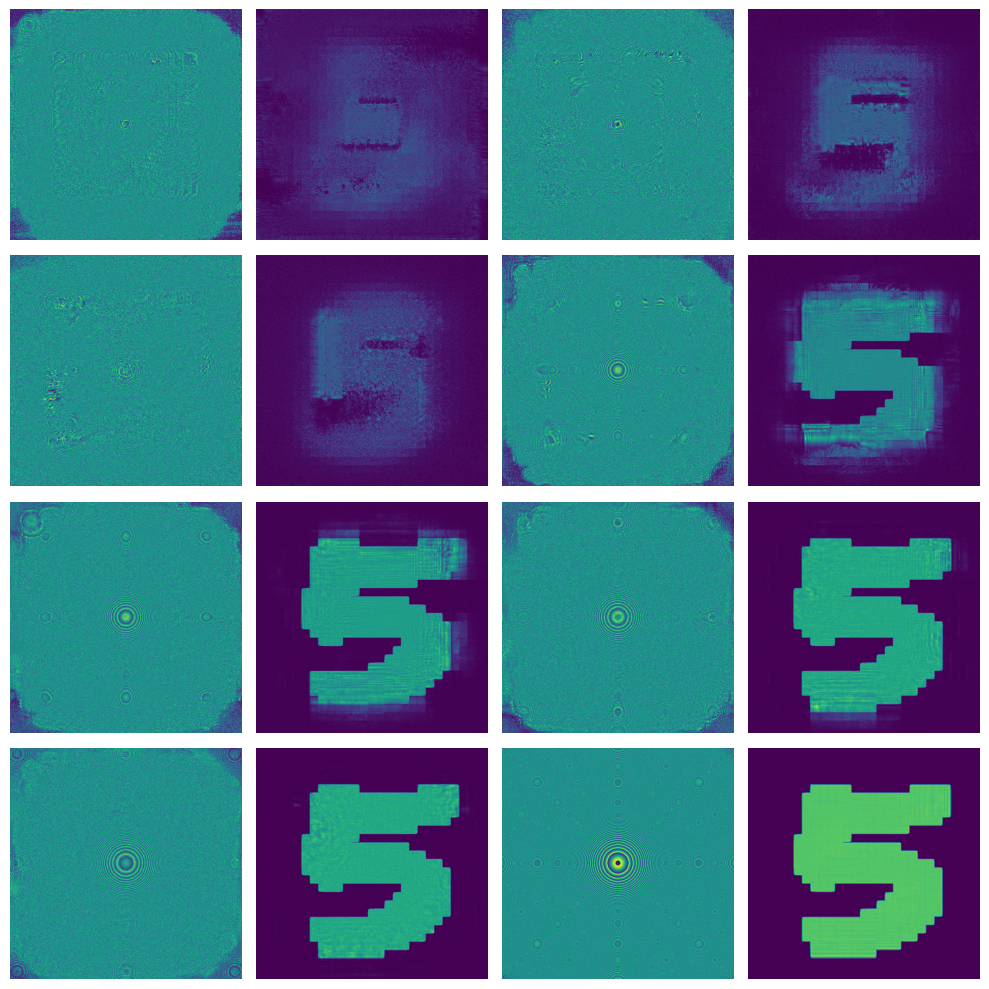

In [33]:
fig,ax = plt.subplots(4,4, figsize=(10,10))

images = []
lenses = []

for i,k in enumerate(outputs):
    col = i%2
    row = i//2
    
    #print(row,col)
    
    image = outputs[k][0][3].squeeze().detach()
    lens = outputs[k][-1].detach().squeeze() % (np.pi *2)
    
    images.append(image)
    lenses.append(lens)

    
ax[0][0].imshow(lenses[0])
ax[0][1].imshow(images[0])

ax[0][2].imshow(lenses[1])
ax[0][3].imshow(images[1])

ax[1][0].imshow(lenses[2])
ax[1][1].imshow(images[2])

ax[1][2].imshow(lenses[3])
ax[1][3].imshow(images[3])

ax[2][0].imshow(lenses[4])
ax[2][1].imshow(images[4])

ax[2][2].imshow(lenses[5])
ax[2][3].imshow(images[5])

ax[3][0].imshow(lenses[6])
ax[3][1].imshow(images[6])

ax[3][2].imshow(lenses[7])
ax[3][3].imshow(images[7])
    
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i,j].axis('off')
        
plt.tight_layout()
fig.savefig("lrn_randomInit.pdf")